In [18]:
from tensorflow.python.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tqdm

In [19]:
cats = {'background': [0, 1, 3, 4, 5, 8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24],
 'grass': [2],
 'dog': [9],
 'tree': [6],
 'sky': [7],
 'concrete': [12, 22]}


In [20]:
from google.colab import drive

In [21]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
image_dir = "/content/drive/MyDrive/Data/image_dataset/"
mask_dir = "/content/drive/MyDrive/Data/mask_dataset/"
image_list = os.listdir(image_dir)
mask_list = os.listdir(mask_dir)
image_list.sort()
mask_list.sort()
print(f'Number of images: {len(image_list)}\nNumber of masks: {len(mask_list)}')

Number of images: 361
Number of masks: 361


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


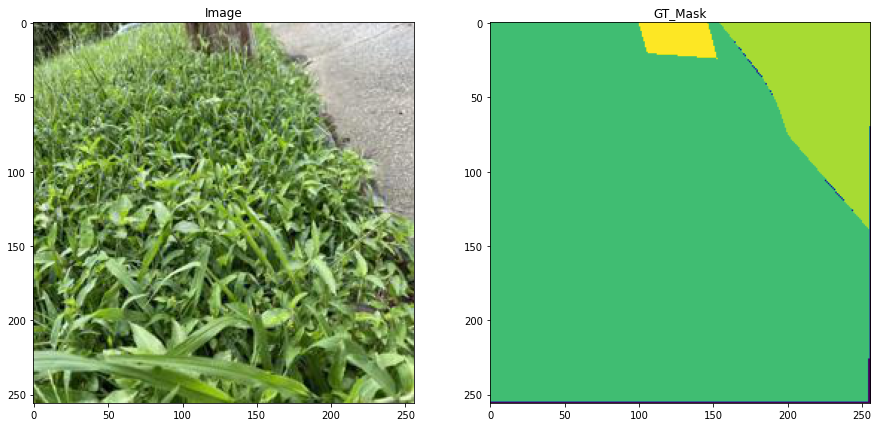

In [23]:
i = 86
test_image = image.img_to_array(image.load_img(f'{image_dir}/{image_list[i]}'))/255.
test_mask = image.img_to_array(image.load_img(f'{mask_dir}/{mask_list[i]}', grayscale=True))
test_mask = np.squeeze(test_mask)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Image')
ax.imshow(test_image)

ax1 = fig.add_subplot(1, 2, 2)
ax1.set_title('GT_Mask')
ax1.imshow(test_mask)

In [24]:
def get_mask(mask_list):
    for m in tqdm.tqdm(tmask_list):
        img = image.load_img(f'{train_dir}/{m}', grayscale=True, target_size=(512, 512))
        img = np.squeeze(image.img_to_array(img))

In [25]:
def make_mask(img):
    mask = np.zeros((img.shape[0], img.shape[1], 6))
    for i in range(-1, 34):
        if i in cats['background']:
            mask[:,:,0] = np.logical_or(mask[:,:,0],(img==i))
        elif i in cats['grass']:
            mask[:,:,1] = np.logical_or(mask[:,:,1],(img==i))
        elif i in cats['dog']:
            mask[:,:,2] = np.logical_or(mask[:,:,2],(img==i))
        elif i in cats['tree']:
            mask[:,:,3] = np.logical_or(mask[:,:,3],(img==i))
        elif i in cats['sky']:
            mask[:,:,4] = np.logical_or(mask[:,:,4],(img==i))
        elif i in cats['concrete']:
            mask[:,:,5] = np.logical_or(mask[:,:,5],(img==i))
        
    mask = np.resize(mask,(img.shape[0]*img.shape[1], 6))
    return mask

In [26]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf


# In[2]:


def DilatedNet(img_height, img_width, nclasses, use_ctx_module=False, bn=False):
    print('. . . . .Building DilatedNet. . . . .')
    def bilinear_upsample(image_tensor):
        upsampled = tf.image.resize_bilinear(image_tensor, size=(img_height, img_width))
        return upsampled
    
    def conv_block(conv_layers, tensor, nfilters, size=3, name='', padding='same', dilation_rate=1,pool=False):
        if dilation_rate == 1:
            conv_type = 'conv'
        else:
            conv_type = 'dilated_conv'
        for i in range(conv_layers):
            tensor = Conv2D(nfilters, size, padding=padding, use_bias=False, dilation_rate=dilation_rate, name=f'block{name}_{conv_type}{i+1}')(tensor)
            if bn:
                tensor = BatchNormalization(name=f'block{name}_bn{i+1}')(tensor)
            tensor = Activation('relu', name=f'block{name}_relu{i+1}')(tensor)
        if pool:
            tensor = MaxPooling2D(2, name=f'block{name}_pool')(tensor)
        return tensor
       
    nfilters = 64
    img_input = Input(shape=(img_height, img_width, 3))
    x = conv_block(conv_layers=2,tensor=img_input, nfilters=nfilters*1, size=3, pool=True, name=1)
    x = conv_block(conv_layers=2,tensor=x, nfilters=nfilters*2, size=3, pool=True, name=2)
    x = conv_block(conv_layers=3,tensor=x, nfilters=nfilters*4, size=3, pool=True, name=3)
    x = conv_block(conv_layers=3,tensor=x, nfilters=nfilters*8, size=3, name=4)
    x = conv_block(conv_layers=3,tensor=x, nfilters=nfilters*8, size=3,dilation_rate=2, name=5)
    x = conv_block(conv_layers=1,tensor=x, nfilters=nfilters*64, size=7,dilation_rate=4, name='_FCN1')
    x = Dropout(0.5)(x)
    x = conv_block(conv_layers=1,tensor=x, nfilters=nfilters*64, size=1, name='_FCN2')
    x = Dropout(0.5)(x)  
    x = Conv2D(filters=nclasses, kernel_size=1, padding='same', name=f'frontend_output')(x)
    if use_ctx_module:
        x = conv_block(conv_layers=2, tensor=x, nfilters=nclasses*2, size=3, name='_ctx1')
        x = conv_block(conv_layers=1, tensor=x, nfilters=nclasses*4, size=3, name='_ctx2', dilation_rate=2)
        x = conv_block(conv_layers=1, tensor=x, nfilters=nclasses*8, size=3, name='_ctx3', dilation_rate=4)
        x = conv_block(conv_layers=1, tensor=x, nfilters=nclasses*16, size=3, name='_ctx4', dilation_rate=8)
        x = conv_block(conv_layers=1, tensor=x, nfilters=nclasses*32, size=3, name='_ctx5', dilation_rate=16)        
        x = conv_block(conv_layers=1, tensor=x, nfilters=nclasses*32, size=3, name='_ctx7')
        x = Conv2D(filters=nclasses, kernel_size=1, padding='same', name=f'ctx_output')(x)
    x = Lambda(bilinear_upsample, name='bilinear_upsample')(x)
    x = Reshape((img_height*img_width, nclasses))(x)
    x = Activation('softmax', name='final_softmax')(x)
  
    model = Model(inputs=img_input, outputs=x, name='DilatedNet')
    print('. . . . .Building network successful. . . . .')
    return model

In [27]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout, Reshape, Permute
from tensorflow.keras.optimizers import Adadelta, Nadam
from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.utils import multi_gpu_model, plot_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy

# [ 148343025 1162958786  215752525]
# [0.687561014639342, 5.390244151256168, 1.0]
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(img_height, img_width, nclasses=3, filters=64):
# down
    input_layer = Input(shape=(img_height, img_width, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
# output
    output_layer = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Reshape((img_height*img_width, nclasses), input_shape=(img_height, img_width, nclasses))(output_layer)
    output_layer = Activation('softmax')(output_layer)
    
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [28]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout, Reshape, UpSampling2D
from tensorflow.keras.optimizers import Adadelta, Nadam
from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.utils import multi_gpu_model, plot_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy

# [ 148343025 1162958786  215752525]
# [0.687561014639342, 5.390244151256168, 1.0]
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=2, padding='same', strides=(2, 2)):
    y = UpSampling2D(size=(size, size))(tensor)
    y = Conv2D(nfilters, kernel_size=(size, size), padding=padding)(y)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(img_height, img_width, nclasses=3, filters=64):
# down
    input_layer = Input(shape=(img_height, img_width, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
# output
    output_layer = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    output_layer = Reshape((img_height*img_width, nclasses), input_shape=(img_height, img_width, nclasses))(output_layer)
    output_layer = Activation('softmax')(output_layer)
    
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    print('Created and loaded model')
    return model    

In [30]:
import tensorflow as tf
from tensorflow.keras import layers


# Build the model
def unet_model(classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
    s = inputs

    # Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(classes, (1, 1), activation='softmax')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     model.summary()
    return model

In [32]:

  
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adadelta, Nadam
from tensorflow.keras.models import Model, load_model
# from tensorflow.python.keras.utils import multi_gpu_model, plot_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
# from multiclassunet import Unet
import tqdm
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback
# from dilatednet import DilatedNet

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def total_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + (3*dice_loss(y_true, y_pred))
    return loss

batch_size = 2
samples = 361
steps = samples//batch_size
img_height, img_width = 256, 256
classes = 6
filters_n = 64

class seg_gen(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        idx = np.random.randint(0, 361, batch_size)
        batch_x, batch_y = [], []
        drawn = 0
        for i in idx:
            _image = image.img_to_array(image.load_img(f'{image_dir}/{image_list[i]}', target_size=(img_height, img_width)))/255.   
            img = image.img_to_array(image.load_img(f'{mask_dir}/{mask_list[i]}', grayscale=True, target_size=(img_height, img_width)))
            labels = np.unique(img)
            if len(labels) < 3:
                idx = np.random.randint(0, 361, batch_size-drawn)
                continue
            img = np.squeeze(img)
            mask = np.zeros((img.shape[0], img.shape[1], 6))
            for i in range(-1, 34):
                if i in cats['background']:
                    mask[:,:,0] = np.logical_or(mask[:,:,0],(img==i))
                elif i in cats['grass']:
                    mask[:,:,1] = np.logical_or(mask[:,:,1],(img==i))
                elif i in cats['dog']:
                    mask[:,:,2] = np.logical_or(mask[:,:,2],(img==i))
                elif i in cats['tree']:
                    mask[:,:,3] = np.logical_or(mask[:,:,3],(img==i))
                elif i in cats['sky']:
                    mask[:,:,4] = np.logical_or(mask[:,:,4],(img==i))
                elif i in cats['concrete']:
                    mask[:,:,5] = np.logical_or(mask[:,:,5],(img==i))
            mask = np.resize(mask,(img_height*img_width, 6))
            batch_y.append(mask)
            batch_x.append(_image)
            drawn += 1
        return np.array(batch_x), np.array(batch_y)


class visualize(Callback):
    def on_epoch_end(self, epoch, logs):
        print(f'\nGenerating output at epoch : {epoch}')
        i = 567
        img = image.img_to_array(image.load_img(f'{image_dir}/{image_list[i]}'))/255.    
        dims = img.shape
        x = cv2.resize(img, (256, 256))
        x = np.float32(x)/255.
        z = unet.predict(np.expand_dims(x, axis=0))
        z = np.squeeze(z)
        z = z.reshape(256, 256, 8)
        z = cv2.resize(z, (dims[1], dims[0]))
        y = np.argmax(z, axis=2)
        
        grass = np.zeros_like(y)
        tree = np.zeros_like(y)
        sky = np.zeros_like(y)
        grass[y==2] = 255.
        tree[y==6] = 255.
        sky[y==7] = 255.
        
        result = img.copy()
        alpha = 0.4
        img[:,:,1] = grass
        img[:,:,2] = sky
        img[:,:,0] = tree

        cv2.addWeighted(img, alpha, result, 1-alpha, 0, result)
        cv2.imwrite(f'outputs/{epoch}.png', cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
        print('Wrote file to disk')

def get_model():
    return unet_model(classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

unet = get_model()
# p_unet = multi_gpu_model(unet, 4)
unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[dice_coeff, 'accuracy'])
# tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='/content/drive/MyDrive/Data/pdilated.h5', monitor='acc', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='acc', patience=6, verbose=1)
vis = visualize()
callbacks = [mc, es]
train_gen = seg_gen(image_list, mask_list, batch_size)


unet.fit(train_gen, steps_per_epoch=steps, epochs=8, callbacks=callbacks, workers=2)
print('Saving final weights')
unet.save_weights('/content/drive/MyDrive/Data/dilated.h5')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Epoch 1/8


ValueError: ignored